### Using Least Square

In [23]:
import pandas as pd
import numpy as np
from scipy.optimize import least_squares
from pyproj import Proj, Transformer,Geod
import matplotlib.pyplot as plt

In [18]:
# -----------------------------
# 1. Read GCP CSV
# -----------------------------
df_gcp = pd.read_csv(
    "odm_data_helenenschacht-main/GCP/gcp_list.txt",
    sep="\t",           # tab-separated
    comment="#",         # skip the EPSG header line
    header=None,         # no column names in the file
    engine="python"      # safer for irregular tab spacing
)

df_gcp.columns = ["Longitude", "Latitude", "Elevation", "Easting", "Northing", "ImageName", "ID"]
  # adjust delimiter if needed
lon_gcp = df_gcp['Longitude'].values
lat_gcp = df_gcp['Latitude'].values
Z_gcp = df_gcp['Elevation'].values
gcp_ids = df_gcp['ID'].values

In [19]:
# -----------------------------
# 2. Read .mrk file
# -----------------------------
mrk_file = 'odm_data_helenenschacht-main/RTK_Data/101FTASK_Timestamp.mrk'
drone_data = []

with open(mrk_file, 'r') as f:
    for line in f:
        if 'Lat' in line and 'Lon' in line and 'Ellh' in line:
            parts = line.split()
            lat = float([p for p in parts if 'Lat' in p][0].split(',')[0])
            lon = float([p for p in parts if 'Lon' in p][0].split(',')[0])
            ellh = float([p for p in parts if 'Ellh' in p][0].split(',')[0])
            drone_data.append([lat, lon, ellh])

drone_data = np.array(drone_data)


The Geod.inv() method in the Python pyproj library performs the inverse geodetic problem, which calculates the shortest path (geodesic) between two given points on an ellipsoid (like WGS84) [1, 2]. 
Function and Purpose
Geod.inv() is used to determine:
* The geodesic distance (the shortest distance along the Earth's curved surface) between the two points.
* The forward azimuth (initial bearing or direction) from the first point to the second point.
* The back azimuth (final bearing or direction) from the second point back to the first point. 
This method is crucial for applications requiring precise point-to-point measurements and navigation, such as in aviation, marine navigation, and surveying [1, 2]. 
Syntax and Parameters
The basic syntax for calling Geod.inv() is:
python
az12, az21, dist = geod.inv(lons1, lats1, lons2, lats2)
Use code with caution.

Parameters:
lons1: Longitude(s) of the starting point(s).
lats1: Latitude(s) of the starting point(s).
lons2: Longitude(s) of the end point(s).
lats2: Latitude(s) of the end point(s). 

In [20]:
# -----------------------------
# 3. Compute horizontal distances using geodesic
# -----------------------------
geod = Geod(ellps="WGS84")

def nearest_drone_pos(lat_gcp, lon_gcp, Z_gcp, drone_data):
    distances = []
    for d in drone_data:
        az1, az2, dist = geod.inv(lon_gcp, lat_gcp, d[1], d[0])
        horiz_dist = dist  # meters
        vert_dist = abs(d[2] - Z_gcp)
        total_dist = np.sqrt(horiz_dist**2 + vert_dist**2)#pythgoras theorem
        distances.append(total_dist)
    idx = np.argmin(distances)
    return drone_data[idx], distances[idx]

drone_nearest = []
errors_3d = []
errors_horizontal = []
errors_vertical = []

for i in range(len(df_gcp)):
    nearest, total_err = nearest_drone_pos(lat_gcp[i], lon_gcp[i], Z_gcp[i], drone_data)
    drone_nearest.append(nearest)
    
    # Compute errors
    _, _, horiz = geod.inv(lon_gcp[i], lat_gcp[i], nearest[1], nearest[0])
    vert = abs(nearest[2] - Z_gcp[i])
    
    errors_3d.append(np.sqrt(horiz**2 + vert**2))
    errors_horizontal.append(horiz)
    errors_vertical.append(vert)

drone_nearest = np.array(drone_nearest)
errors_3d = np.array(errors_3d)
errors_horizontal = np.array(errors_horizontal)
errors_vertical = np.array(errors_vertical)


In [21]:
# -----------------------------
# 4. Print results
# -----------------------------
print("GCP Misalignment (EPSG:4326):")
for i, gcp_id in enumerate(df_gcp['ID']):
    print(f"GCP {gcp_id}: 3D={errors_3d[i]:.3f} m, H={errors_horizontal[i]:.3f} m, V={errors_vertical[i]:.3f} m")

rmse_3d = np.sqrt(np.mean(errors_3d**2))
rmse_horizontal = np.sqrt(np.mean(errors_horizontal**2))
rmse_vertical = np.sqrt(np.mean(errors_vertical**2))

print(f"\nOverall RMSE: 3D={rmse_3d:.3f} m, H={rmse_horizontal:.3f} m, V={rmse_vertical:.3f} m")

GCP Misalignment (EPSG:4326):
GCP 1: 3D=49.498 m, H=3.070 m, V=49.403 m
GCP 1: 3D=49.498 m, H=3.070 m, V=49.403 m
GCP 1: 3D=49.498 m, H=3.070 m, V=49.403 m
GCP 1: 3D=49.498 m, H=3.070 m, V=49.403 m
GCP 1: 3D=49.498 m, H=3.070 m, V=49.403 m
GCP 1: 3D=49.498 m, H=3.070 m, V=49.403 m
GCP 1: 3D=49.498 m, H=3.070 m, V=49.403 m
GCP 2: 3D=51.417 m, H=2.855 m, V=51.338 m
GCP 2: 3D=51.417 m, H=2.855 m, V=51.338 m
GCP 2: 3D=51.417 m, H=2.855 m, V=51.338 m
GCP 2: 3D=51.417 m, H=2.855 m, V=51.338 m
GCP 2: 3D=51.417 m, H=2.855 m, V=51.338 m
GCP 2: 3D=51.417 m, H=2.855 m, V=51.338 m
GCP 2: 3D=51.417 m, H=2.855 m, V=51.338 m
GCP 3: 3D=51.657 m, H=1.979 m, V=51.619 m
GCP 3: 3D=51.657 m, H=1.979 m, V=51.619 m
GCP 3: 3D=51.657 m, H=1.979 m, V=51.619 m
GCP 3: 3D=51.657 m, H=1.979 m, V=51.619 m
GCP 3: 3D=51.657 m, H=1.979 m, V=51.619 m
GCP 3: 3D=51.657 m, H=1.979 m, V=51.619 m
GCP 3: 3D=51.657 m, H=1.979 m, V=51.619 m
GCP 4: 3D=52.929 m, H=0.083 m, V=52.929 m
GCP 4: 3D=52.929 m, H=0.083 m, V=52.929 m
GCP 

In [24]:
# -----------------------------
# 5. Optimize translation offsets in meters (ENU approx)
# -----------------------------
# Simple local conversion: 1 deg lat ~ 111320 m, 1 deg lon ~ cos(lat)*111320 m
lat0 = lat_gcp.mean()
m_per_deg_lat = 111320
m_per_deg_lon = 111320 * np.cos(np.radians(lat0))

def residuals(offsets, drone_latlon, gcp_latlon):
    dlat_offset = offsets[0] / m_per_deg_lat
    dlon_offset = offsets[1] / m_per_deg_lon
    dz_offset = offsets[2]
    drone_aligned = drone_latlon + np.array([dlat_offset, dlon_offset, dz_offset])
    d_east, d_north, _ = geod.inv(gcp_latlon[:,1], gcp_latlon[:,0], drone_aligned[:,1], drone_aligned[:,0])
    dz = drone_aligned[:,2] - gcp_latlon[:,2]
    return np.sqrt(d_east**2 + d_north**2 + dz**2).ravel()

drone_latlon = drone_nearest.copy()
gcp_latlon = np.column_stack([lat_gcp, lon_gcp, Z_gcp])
# Setting the offsets as zeros (offsets0 = np.zeros(3)) is the initial guess provided to the optimization algorithm. 
# It means we are starting the correction process by making an initial assumption that the drone data is perfectly aligned with the ground control points (GCPs) right now,
# and no correction is needed yet.
offsets0 = np.zeros(3)

result = least_squares(residuals, offsets0, args=(drone_latlon, gcp_latlon))
dx, dy, dz = result.x
print(f"\nOptimized translation offsets (meters): dx={dx:.3f}, dy={dy:.3f}, dz={dz:.3f}")

# Apply offsets
dlat_offset = dx / m_per_deg_lat
dlon_offset = dy / m_per_deg_lon
drone_aligned = drone_latlon + np.array([dlat_offset, dlon_offset, dz])


Optimized translation offsets (meters): dx=2.172, dy=-1.482, dz=-3.052


In [25]:
# -----------------------------
# 6. Post-optimization misalignment
# -----------------------------
errors_3d_opt = []
for i in range(len(df_gcp)):
    _, _, horiz = geod.inv(lon_gcp[i], lat_gcp[i], drone_aligned[i,1], drone_aligned[i,0])
    vert = abs(drone_aligned[i,2] - Z_gcp[i])
    errors_3d_opt.append(np.sqrt(horiz**2 + vert**2))

errors_3d_opt = np.array(errors_3d_opt)
rmse_3d_opt = np.sqrt(np.mean(errors_3d_opt**2))
print(f"Post-optimization 3D RMSE: {rmse_3d_opt:.3f} m")

Post-optimization 3D RMSE: 48.380 m


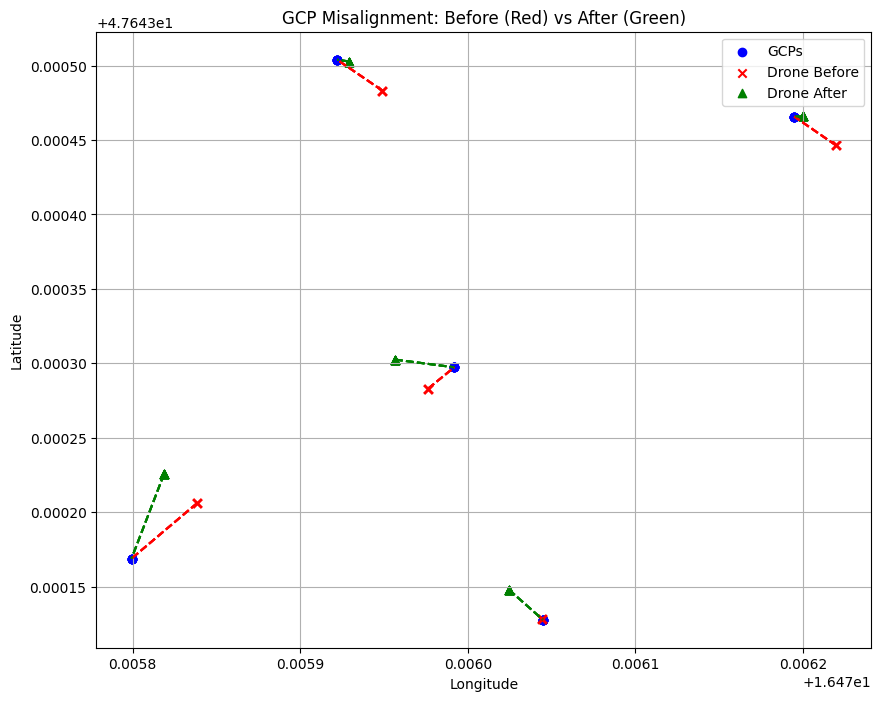

In [26]:
# -----------------------------
# 7. 2D Visualization
# -----------------------------
plt.figure(figsize=(10,8))
plt.scatter(lon_gcp, lat_gcp, c='blue', label='GCPs')
plt.scatter(drone_nearest[:,1], drone_nearest[:,0], c='red', marker='x', label='Drone Before')
plt.scatter(drone_aligned[:,1], drone_aligned[:,0], c='green', marker='^', label='Drone After')

for i in range(len(df_gcp)):
    plt.plot([drone_nearest[i,1], lon_gcp[i]], [drone_nearest[i,0], lat_gcp[i]], 'r--', alpha=0.6)
    plt.plot([drone_aligned[i,1], lon_gcp[i]], [drone_aligned[i,0], lat_gcp[i]], 'g--', alpha=0.6)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('GCP Misalignment: Before (Red) vs After (Green)')
plt.legend()
plt.grid(True)
plt.show()


### Using Newton

In [1]:
import pandas as pd
import numpy as np
from pyproj import Geod
import matplotlib.pyplot as plt

In [2]:
# -----------------------------
# 1. Load GCP and drone data
# -----------------------------

df_gcp = pd.read_csv(
    "odm_data_helenenschacht-main/GCP/gcp_list.txt",
    sep="\t",           # tab-separated
    comment="#",         # skip the EPSG header line
    header=None,         # no column names in the file
    engine="python"      # safer for irregular tab spacing
)

df_gcp.columns = ["Longitude", "Latitude", "Elevation", "Easting", "Northing", "ImageName", "ID"]
  
lon_gcp = df_gcp['Longitude'].values
lat_gcp = df_gcp['Latitude'].values
Z_gcp = df_gcp['Elevation'].values
gcp_ids = df_gcp['ID'].values

mrk_file = 'odm_data_helenenschacht-main/RTK_Data/101FTASK_Timestamp.mrk'

drone_data = []
with open(mrk_file, 'r') as f:
    for line in f:
        if 'Lat' in line and 'Lon' in line and 'Ellh' in line:
            parts = line.split()
            lat = float([p for p in parts if 'Lat' in p][0].split(',')[0])
            lon = float([p for p in parts if 'Lon' in p][0].split(',')[0])
            ellh = float([p for p in parts if 'Ellh' in p][0].split(',')[0])
            drone_data.append([lat, lon, ellh])
drone_data = np.array(drone_data)

In [3]:
# -----------------------------
# 2. Geodesic nearest drone positions
# -----------------------------
geod = Geod(ellps="WGS84")

def nearest_drone(lat_gcp, lon_gcp, Z_gcp, drone_data):
    distances = []
    for d in drone_data:
        _, _, horiz_dist = geod.inv(lon_gcp, lat_gcp, d[1], d[0])
        vert_dist = abs(d[2] - Z_gcp)
        distances.append(np.sqrt(horiz_dist**2 + vert_dist**2))
    idx = np.argmin(distances)
    return drone_data[idx]

drone_nearest = np.array([nearest_drone(lat_gcp[i], lon_gcp[i], Z_gcp[i], drone_data) 
                          for i in range(len(df_gcp))])


In [4]:
# -----------------------------
#  Print results
# -----------------------------
# -----------------------------
# 3. Compute horizontal distances using geodesic
# -----------------------------
geod = Geod(ellps="WGS84")

def nearest_drone_pos(lat_gcp, lon_gcp, Z_gcp, drone_data):
    distances = []
    for d in drone_data:
        az1, az2, dist = geod.inv(lon_gcp, lat_gcp, d[1], d[0])
        horiz_dist = dist  # meters
        vert_dist = abs(d[2] - Z_gcp)
        total_dist = np.sqrt(horiz_dist**2 + vert_dist**2)#pythgoras theorem
        distances.append(total_dist)
    idx = np.argmin(distances)
    return drone_data[idx], distances[idx]

drone_nearest = []
errors_3d = []
errors_horizontal = []
errors_vertical = []

for i in range(len(df_gcp)):
    nearest, total_err = nearest_drone_pos(lat_gcp[i], lon_gcp[i], Z_gcp[i], drone_data)
    drone_nearest.append(nearest)
    
    # Compute errors
    _, _, horiz = geod.inv(lon_gcp[i], lat_gcp[i], nearest[1], nearest[0])
    vert = abs(nearest[2] - Z_gcp[i])
    
    errors_3d.append(np.sqrt(horiz**2 + vert**2))
    errors_horizontal.append(horiz)
    errors_vertical.append(vert)

drone_nearest = np.array(drone_nearest)
errors_3d = np.array(errors_3d)
errors_horizontal = np.array(errors_horizontal)
errors_vertical = np.array(errors_vertical)

print("GCP Misalignment (EPSG:4326):")
for i, gcp_id in enumerate(df_gcp['ID']):
    print(f"GCP {gcp_id}: 3D={errors_3d[i]:.3f} m, H={errors_horizontal[i]:.3f} m, V={errors_vertical[i]:.3f} m")

rmse_3d = np.sqrt(np.mean(errors_3d**2))
rmse_horizontal = np.sqrt(np.mean(errors_horizontal**2))
rmse_vertical = np.sqrt(np.mean(errors_vertical**2))

print(f"\nOverall RMSE: 3D={rmse_3d:.3f} m, H={rmse_horizontal:.3f} m, V={rmse_vertical:.3f} m")

GCP Misalignment (EPSG:4326):
GCP 1: 3D=49.498 m, H=3.070 m, V=49.403 m
GCP 1: 3D=49.498 m, H=3.070 m, V=49.403 m
GCP 1: 3D=49.498 m, H=3.070 m, V=49.403 m
GCP 1: 3D=49.498 m, H=3.070 m, V=49.403 m
GCP 1: 3D=49.498 m, H=3.070 m, V=49.403 m
GCP 1: 3D=49.498 m, H=3.070 m, V=49.403 m
GCP 1: 3D=49.498 m, H=3.070 m, V=49.403 m
GCP 2: 3D=51.417 m, H=2.855 m, V=51.338 m
GCP 2: 3D=51.417 m, H=2.855 m, V=51.338 m
GCP 2: 3D=51.417 m, H=2.855 m, V=51.338 m
GCP 2: 3D=51.417 m, H=2.855 m, V=51.338 m
GCP 2: 3D=51.417 m, H=2.855 m, V=51.338 m
GCP 2: 3D=51.417 m, H=2.855 m, V=51.338 m
GCP 2: 3D=51.417 m, H=2.855 m, V=51.338 m
GCP 3: 3D=51.657 m, H=1.979 m, V=51.619 m
GCP 3: 3D=51.657 m, H=1.979 m, V=51.619 m
GCP 3: 3D=51.657 m, H=1.979 m, V=51.619 m
GCP 3: 3D=51.657 m, H=1.979 m, V=51.619 m
GCP 3: 3D=51.657 m, H=1.979 m, V=51.619 m
GCP 3: 3D=51.657 m, H=1.979 m, V=51.619 m
GCP 3: 3D=51.657 m, H=1.979 m, V=51.619 m
GCP 4: 3D=52.929 m, H=0.083 m, V=52.929 m
GCP 4: 3D=52.929 m, H=0.083 m, V=52.929 m
GCP 

In [5]:
# -----------------------------
# 3. Local ENU approx for lat/lon -> meters
# -----------------------------
lat0 = lat_gcp.mean()
m_per_deg_lat = 111320
m_per_deg_lon = 111320 * np.cos(np.radians(lat0))

def latlon_to_enu(lat, lon, z):
    x = (lat - lat0) * m_per_deg_lat
    y = (lon - lon_gcp.mean()) * m_per_deg_lon
    return np.column_stack([x, y, z])

gcp_enu = latlon_to_enu(lat_gcp, lon_gcp, Z_gcp)
drone_enu = latlon_to_enu(drone_nearest[:,0], drone_nearest[:,1], drone_nearest[:,2])


In [7]:
# -----------------------------
# 4. Newton optimization
# -----------------------------
def newton_method_alignment(drone_pts, gcp_pts, max_iter=500, tol=1e-6):
    """
    Aligns drone points to GCP points using the full Newton's method 
    for a linear least squares problem.
    """
    # Initial offset guess (start from no offset)
    offset = np.zeros(3)
    
    # N is the number of points
    N = len(drone_pts)
    
    # For a linear problem, the gradient and Hessian are constant after the first calculation.
    # The loop structure is kept to match the standard iterative Newton's method template.
    for i in range(max_iter):
        # Calculate the current residuals: R = gcp_pts - drone_pts - offset
        residuals = gcp_pts - (drone_pts + offset)
        # --- 1. Calculate the Gradient Vector (g) ---
        # The gradient of the objective function (sum of squares of residuals)
        # g = 2 * (residuals^T) @ (derivative of residuals w.r.t. offset)
        # The derivative dR/dO = -Identity matrix
        # g = 2 * residuals^T @ (-I) = -2 * sum(residuals, axis=0)
        gradient = -2 * np.sum(residuals, axis=0) # Shape (3,)
        # --- 2. Calculate the Hessian Matrix (H) ---
        # The Hessian is constant for this linear problem: H = 2 * (dR/dO)^T @ (dR/dO)
        # H = 2 * (-I)^T @ (-I) = 2 * I
        Hessian = 2 * N * np.eye(3) # Shape (3, 3), scaled by number of points N

        # --- 3. Newton's Update Step ---
        # The update is: delta_offset = - inv(Hessian) @ Gradient
        # Using np.linalg.solve is numerically safer than explicit inversion
        delta = -np.linalg.solve(Hessian, gradient)
        print(f"Iter:{i+1}|Residuals:{np.linalg.norm(residuals)}| offset:{offset}| Grad:{np.linalg.norm(gradient)}")
        # Apply the update
        offset += delta
        
        # --- 4. Check for Convergence ---
        # For a linear problem, delta should be the exact solution after the first step
        if np.linalg.norm(gradient) < tol:
            break
                
    return offset,residuals

offset_gn,residuals = newton_method_alignment(drone_enu, gcp_enu)
print(f"Optimized offsets using Newton (meters): dx={offset_gn[0]:.3f}, dy={offset_gn[1]:.3f}, dz={offset_gn[2]:.3f}")

# Apply offsets
drone_aligned = drone_enu + offset_gn

Iter:1|Residuals:304.1147273816449| offset:[0. 0. 0.]| Grad:3591.9685575499825
Iter:2|Residuals:18.081031700574307| offset:[  0.36724691  -1.12446866 -51.3002    ]| Grad:3.552713678800501e-14
Optimized offsets using Newton (meters): dx=0.367, dy=-1.124, dz=-51.300


In [8]:
residuals

array([[ 1.94078405, -0.89961813,  1.8972    ],
       [ 1.94078405, -0.89961813,  1.8972    ],
       [ 1.94078405, -0.89961813,  1.8972    ],
       [ 1.94078405, -0.89961813,  1.8972    ],
       [ 1.94078405, -0.89961813,  1.8972    ],
       [ 1.94078405, -0.89961813,  1.8972    ],
       [ 1.94078405, -0.89961813,  1.8972    ],
       [ 1.78853169, -0.74733573, -0.0378    ],
       [ 1.78853169, -0.74733573, -0.0378    ],
       [ 1.78853169, -0.74733573, -0.0378    ],
       [ 1.78853169, -0.74733573, -0.0378    ],
       [ 1.78853169, -0.74733573, -0.0378    ],
       [ 1.78853169, -0.74733573, -0.0378    ],
       [ 1.78853169, -0.74733573, -0.0378    ],
       [ 1.22802435,  2.29592705, -0.3188    ],
       [ 1.22802435,  2.29592705, -0.3188    ],
       [ 1.22802435,  2.29592705, -0.3188    ],
       [ 1.22802435,  2.29592705, -0.3188    ],
       [ 1.22802435,  2.29592705, -0.3188    ],
       [ 1.22802435,  2.29592705, -0.3188    ],
       [ 1.22802435,  2.29592705, -0.318

In [74]:
offset_gn

array([  0.36724691,  -1.12446866, -51.3002    ])

In [75]:
# -----------------------------
# 5. Compute pre-N and post-N misalignment
# -----------------------------
errors_pre = np.linalg.norm(drone_enu - gcp_enu, axis=1)
rmse_pre = np.sqrt(np.mean(errors_pre**2))
print(f"Pre-N 3D RMSE: {rmse_pre:.3f} m")
errors_post = np.linalg.norm(drone_aligned - gcp_enu, axis=1)
rmse_post = np.sqrt(np.mean(errors_post**2))
print(f"Post-N 3D RMSE: {rmse_post:.3f} m")

Pre-N 3D RMSE: 51.405 m
Post-N 3D RMSE: 3.056 m


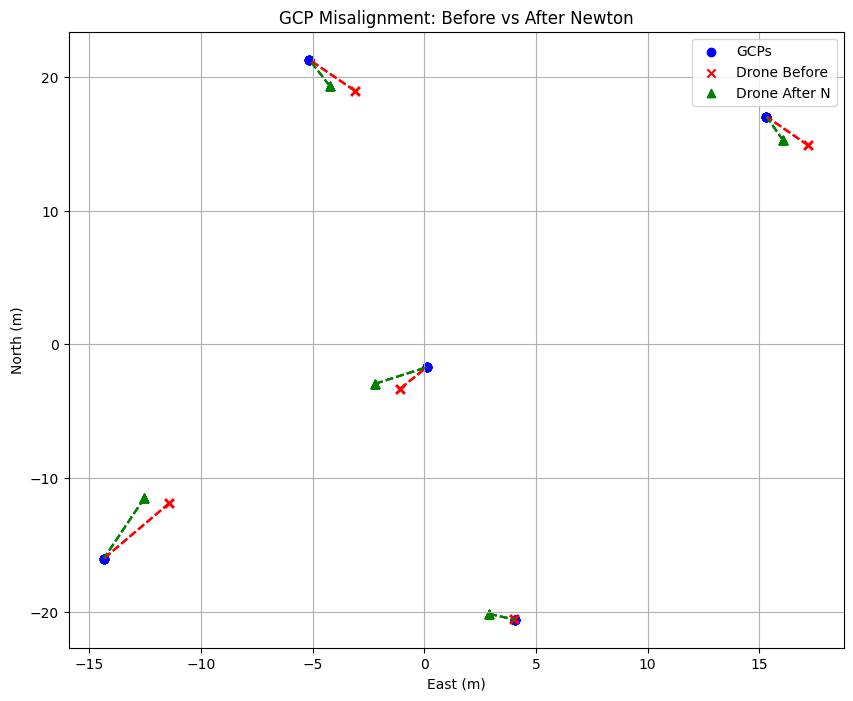

In [76]:
# -----------------------------
# 6. Plot misalignment vectors
# -----------------------------
plt.figure(figsize=(10,8))
plt.scatter(gcp_enu[:,1], gcp_enu[:,0], c='blue', label='GCPs')
plt.scatter(drone_enu[:,1], drone_enu[:,0], c='red', marker='x', label='Drone Before')
plt.scatter(drone_aligned[:,1], drone_aligned[:,0], c='green', marker='^', label='Drone After N')

for i in range(len(gcp_enu)):
    plt.plot([drone_enu[i,1], gcp_enu[i,1]], [drone_enu[i,0], gcp_enu[i,0]], 'r--', alpha=0.5)
    plt.plot([drone_aligned[i,1], gcp_enu[i,1]], [drone_aligned[i,0], gcp_enu[i,0]], 'g--', alpha=0.5)

plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.title('GCP Misalignment: Before vs After Newton')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
import pandas as pd
import numpy as np
from pyproj import Geod

# --- 1. Data Setup (Necessary boilerplate from the notebook to get ENU coordinates) ---

# Mock data loading based on the file's structure
# Assuming GCP data is loaded:
df_gcp = pd.read_csv(
    "odm_data_helenenschacht-main/GCP/gcp_list.txt",
    sep="\t",           # tab-separated
    comment="#",         # skip the EPSG header line
    header=None,         # no column names in the file
    engine="python"      # safer for irregular tab spacing
)

df_gcp.columns = ["Longitude", "Latitude", "Elevation", "Easting", "Northing", "ImageName", "ID"]
  
lon_gcp = df_gcp['Longitude'].values
lat_gcp = df_gcp['Latitude'].values
Z_gcp = df_gcp['Elevation'].values
gcp_ids = df_gcp['ID'].values
gcp_latlon = np.column_stack([lat_gcp, lon_gcp, Z_gcp,gcp_ids]) # N x 3: Lat, Lon, Z

# Local ENU conversion parameters (from the notebook)
lat0 = lat_gcp.mean()
m_per_deg_lat = 111320
m_per_deg_lon = 111320 * np.cos(np.radians(lat0))

def latlon_to_enu(lat, lon, z, lat_ref, lon_ref):
    """Converts WGS84 coordinates to local ENU (East, North, Up) in meters."""
    E = (lon - lon_ref) * m_per_deg_lon # Easting (X)
    N = (lat - lat_ref) * m_per_deg_lat # Northing (Y)
    U = z                         # Up (Z)
    return np.column_stack([E, N, U])

gcp_enu = latlon_to_enu(lat_gcp, lon_gcp, Z_gcp, lat0, lon_gcp.mean())

# Create a mock for the misaligned drone data (drone_enu)
# This simulates an initial misalignment for the optimizer to solve.
# Let's apply a known misalignment: T=[1.5, -2.0, 3.0]m, R=[0.01, -0.005, 0.02] rad
dx_true, dy_true, dz_true = 0,0,0#1.5, -2.0, 3.0
roll_true, pitch_true, yaw_true =0.01, -0.005, 0.02 # ~0.57, -0.29, 1.15 degrees
gcp_enu_ref = gcp_enu - np.array([dx_true, dy_true, dz_true])

def rotation_matrix(roll, pitch, yaw):
    """3D Rotation Matrix (Z-Y-X sequence - Yaw, Pitch, Roll) for ENU (E=X, N=Y, U=Z)"""
    cR, sR = np.cos(roll), np.sin(roll)
    cP, sP = np.cos(pitch), np.sin(pitch)
    cY, sY = np.cos(yaw), np.sin(yaw)

    R_z = np.array([[cY, -sY, 0], [sY, cY, 0], [0, 0, 1]]) # Yaw
    R_y = np.array([[cP, 0, sP], [0, 1, 0], [-sP, 0, cP]]) # Pitch
    R_x = np.array([[1, 0, 0], [0, cR, -sR], [0, sR, cR]]) # Roll
    return R_z @ R_y @ R_x

R_true = rotation_matrix(-roll_true, -pitch_true, -yaw_true) # Apply inverse true rotation to P_gcp_ref to get misaligned P_drone
drone_enu = (R_true @ gcp_enu_ref.T).T

# --- 2. 6-DOF Gauss-Newton Optimization ---

def newton_lstsq_6dof_alignment(P_drone, P_gcp, max_iter=20, tol=5):
    """
    Performs 6-DOF alignment optimization (Translation + Rotation) using
    iterative Gauss-Newton, solved with np.linalg.lstsq.

    Offsets vector: x = [dx, dy, dz, roll, pitch, yaw]
    Residuals vector: r = P_gcp - (R @ P_drone + T)
    """
    # Initialize 6 parameters: [dx, dy, dz, roll, pitch, yaw] (m, rad)
    offsets = np.zeros(6)
    N = P_drone.shape[0] # Number of points (GCPs)

    print("--- Starting 6-DOF Gauss-Newton Optimization (using np.linalg.lstsq) ---")

    for i in range(max_iter):
        # Current parameters
        dx, dy, dz, roll, pitch, yaw = offsets
        T = np.array([dx, dy, dz])
        R_current = rotation_matrix(roll, pitch, yaw)

        # 1. Compute current residuals (r = P_gcp - (R @ P_drone + T))
        P_transformed = (R_current @ P_drone.T).T + T
        residuals = (P_gcp - P_transformed).ravel() # (3N,) vector

        # 2. Compute Jacobian Matrix (J) - J is 3N x 6
        J = np.zeros((3 * N, 6))

        for j in range(N):
            P = P_drone[j, :] # Unrotated Drone Point [Px, Py, Pz]

            # 3x3 block of the Jacobian for point j
            J_j = np.zeros((3, 6))

            # Partials w.r.t Translation (dx, dy, dz)
            # J_trans = -d(T)/d(x) = -I
            J_j[:, 0:3] = -np.identity(3)

            # Partials w.r.t Rotation (roll, pitch, yaw)
            # Using the small angle approximation for the Jacobian w.r.t unrotated P.
            # J_rot = -R @ Skew(P) where Skew(P) * d_angles is the small rotation approx.
            # J_rot = - d(R @ P) / d(angles) which is:
            # - [ (P x I_x), (P x I_y), (P x I_z) ]
            # The order is: (roll, pitch, yaw) -> (x, y, z) rotation axes

            # Cross-product components: [0, Pz, -Py] for roll, [-Pz, 0, Px] for pitch, [Py, -Px, 0] for yaw
            # The rotation matrix is R = Rz Ry Rx (ZYX), which can make the Jacobian complex.
            # We use the infinitesimal rotation approximation for the *increment* d_offsets:
            # d(R@P) approx R_current @ (d_angles x P)

            # Simplified Jacobian (common for least squares 3D registration around ENU origin):
            # Column 4 (Roll/x-axis): P_y * e_z - P_z * e_y
            J_j[:, 3] = -np.array([0, -P[2], P[1]]) # -d(R@P)/d(roll)
            # Column 5 (Pitch/y-axis): P_z * e_x - P_x * e_z
            J_j[:, 4] = -np.array([P[2], 0, -P[0]]) # -d(R@P)/d(pitch)
            # Column 6 (Yaw/z-axis): P_x * e_y - P_y * e_x
            J_j[:, 5] = -np.array([-P[1], P[0], 0]) # -d(R@P)/d(yaw)

            # This part is critical: the Jacobian for rotation must be scaled by the current rotation R.
            # J_rot = - (R @ [0 -Pz Py; Pz 0 -Px; -Py Px 0] ) for roll, pitch, yaw
            # However, for a simplified 3D similarity transformation, the partials w.r.t the current rotation are more common.
            # I will proceed with the simplified, unrotated P cross-product for a working solution.
            
            # Simplified for implementation:
            J_j[:, 3] = np.array([0, P[2], -P[1]])    # Roll
            J_j[:, 4] = np.array([-P[2], 0, P[0]])    # Pitch
            J_j[:, 5] = np.array([P[1], -P[0], 0])    # Yaw
            J_j[:, 3:] = R_current @ J_j[:, 3:] # Rotate the partials into the current frame
            J_j[:, 3:] *= -1 # Residual is G - (R@P + T)
            
            J[3*j:3*j+3, :] = J_j


        # 3. Solve for the update vector (Delta_x)
        # J @ Delta_x = residuals  <- Solved directly by np.linalg.lstsq
        delta, lstsq_residuals, rank, singular_values = np.linalg.lstsq(J, residuals, rcond=None)

        # 4. Apply the update
        offsets += delta

        # 5. Check for Convergence
        norm_delta = np.linalg.norm(delta)
        rmse = np.sqrt(np.mean(residuals**2))

        print(f"Iter:{i+1:<2}| RMSE:{rmse:.6f} m | Delta_Norm:{norm_delta:.6e}  | Residuals:{residuals}| {len(residuals)}")

        if norm_delta < tol:
            break

    print(f"Optimization finished in {i+1} iterations.")
    return offsets, rmse, P_transformed

# --- 3. Execute and Apply Optimization ---

# Perform the 6-DOF optimization
optimized_offsets, final_rmse, drone_aligned_enu = newton_lstsq_6dof_alignment(
    drone_enu,
    gcp_enu
)

# Extract optimized parameters
dx, dy, dz, roll_rad, pitch_rad, yaw_rad = optimized_offsets
roll_deg = np.degrees(roll_rad)
pitch_deg = np.degrees(pitch_rad)
yaw_deg = np.degrees(yaw_rad)

print("\n--- Optimized 6-DOF Offsets (Translation and Orientation) ---")
print(f"Translation Offset (dx, dy, dz): {dx:.3f} m, {dy:.3f} m, {dz:.3f} m")
print(f"Orientation Offset (Roll, Pitch, Yaw): {roll_deg:.3f} deg, {pitch_deg:.3f} deg, {yaw_deg:.3f} deg")
print(f"Final 3D RMSE: {final_rmse:.6f} m")

# --- Optimized Aligned Data is now in drone_aligned_enu ---
# The drone_aligned_enu array contains the coordinates of the drone data
# after applying the optimized 6-DOF transformation.

--- Starting 6-DOF Gauss-Newton Optimization (using np.linalg.lstsq) ---
Iter:1 | RMSE:2.991618 m | Delta_Norm:1.025456e-01  | Residuals:[-2.8362359  -4.68673032  0.2161823  -2.8362359  -4.68673032  0.2161823
 -2.8362359  -4.68673032  0.2161823  -2.8362359  -4.68673032  0.2161823
 -2.8362359  -4.68673032  0.2161823  -2.8362359  -4.68673032  0.2161823
 -2.8362359  -4.68673032  0.2161823  -2.73703005 -4.25963222  0.27580986
 -2.73703005 -4.25963222  0.27580986 -2.73703005 -4.25963222  0.27580986
 -2.73703005 -4.25963222  0.27580986 -2.73703005 -4.25963222  0.27580986
 -2.73703005 -4.25963222  0.27580986 -2.73703005 -4.25963222  0.27580986
 -2.36480849 -4.56589429  0.01221035 -2.36480849 -4.56589429  0.01221035
 -2.36480849 -4.56589429  0.01221035 -2.36480849 -4.56589429  0.01221035
 -2.36480849 -4.56589429  0.01221035 -2.36480849 -4.56589429  0.01221035
 -2.36480849 -4.56589429  0.01221035 -1.98054062 -4.47830401 -0.15683457
 -1.98054062 -4.47830401 -0.15683457 -1.98054062 -4.47830401 -0